# Run a sktime model on Amazon SageMaker (Script Mode) 

In [1]:
# install/upgrade needed package
# please restart the notebook after the installation finished
!pip install -q -U sagemaker

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()

## Prepare our dataset

In [5]:
import pandas as pd
import numpy as np

airline_dataset = pd.read_csv('../Sample-Data/airline.csv')
airline_dataset

,Period,Number of airline passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
...,...,...
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0


## Upload dataset to S3 bucket so it can be passed to our Training Job

In [6]:
prefix = 'sklearn-sktime-airline'

training = session.upload_data(path='../Sample-Data/airline.csv', key_prefix=prefix + "/training")
output   = 's3://{}/{}/output/'.format(bucket, prefix)
print(training)
print(output)

s3://sagemaker-eu-west-1-502452531878/sklearn-sktime-airline/training/airline.csv
s3://sagemaker-eu-west-1-502452531878/sklearn-sktime-airline/output/


## Defining SageMaker Training Job

In [8]:
from sagemaker.sklearn import SKLearn

sk_model = SKLearn(entry_point='script-training.py',
             role=sagemaker.get_execution_role(),
             framework_version='0.23-1',
             instance_count=1, 
             instance_type='ml.m5.large',
             output_path=output,
             base_job_name='sktime-test-model')

sk_model.fit({'training':training})

2021-09-12 19:49:02 Starting - Starting the training job...
2021-09-12 19:49:04 Starting - Launching requested ML instancesProfilerReport-1631476142: InProgress
......
2021-09-12 19:50:21 Starting - Preparing the instances for training......
2021-09-12 19:51:31 Downloading - Downloading input data...
2021-09-12 19:52:01 Training - Downloading the training image...
2021-09-12 19:52:25 Training - Training image download completed. Training in progress.2021-09-12 19:52:26,789 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-09-12 19:52:26,791 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-09-12 19:52:26,801 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-09-12 19:52:27,181 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-09-12 19:52:27,192 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-09-12 19:

## Creat a Real-Time inference Endpoint for our trained model

In [70]:
sk_predictor = sk_model.deploy(endpoint_name='sktime-naiveforcaster', initial_instance_count=1, instance_type='ml.m5.large')

# set the predictor input/output configurations
sk_predictor.serializer = sagemaker.serializers.CSVSerializer()
sk_predictor.deserializer = sagemaker.deserializers.NumpyDeserializer()

---------------!

## See our model prediction!

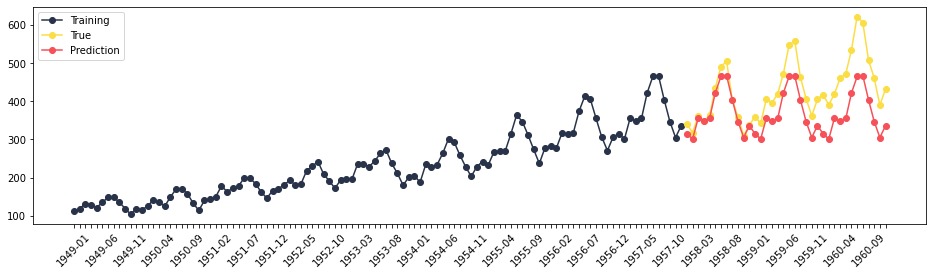

In [72]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 4))

x = airline_dataset.iloc[:,0].values
y = airline_dataset.iloc[:,1].values

x_train = x[:-36]
x_test = x[-36:]
y_train = y[:-36]
y_test = y[-36:]

fh = np.arange(1, len(y_test) + 1)

y_pred = sk_predictor.predict(fh)

x_ticks = [x[i] if i%5 == 0 else '' for i in range(len(x))] 

plt.plot(x_train, y_train, 'o-', c='#28334AFF', label='Training')
plt.plot(x_test, y_test, 'o-', c='#FBDE44FF', label='True')
plt.plot(x_test, y_pred, 'o-', c='#F65058FF', label='Prediction')

plt.xticks(x, x_ticks, rotation=45)
plt.legend()
plt.show()

In [73]:
# make sure to delete the endpoint after you finished
sk_predictor.delete_endpoint()